Author: [Emmanuel Rachelson](https://personnel.isae-supaero.fr/emmanuel-rachelson?lang=en).<br>
License: CC-BY-SA-NC.<br>
The latest version of this tutorial is available at [https://github.com/erachelson/RLtuto](https://github.com/erachelson/RLtuto).

**A few words about the author:**<br>
I am a Reinforcement Learning researcher with a few other scientific (Operations Research, Planning, Machine Learning), professional and non-professional interests. I defended my PhD in 2008 and have occupied both academic and industry positions in research, before joining ISAE-SUPAERO in 2011 as an Associate Professor. I created the [Data and Decision Sciences](https://supaerodatascience.github.io) Master-level curriculum, which is now running with the help of an incredible team of speakers and professors, for even more incredible students. I also founded [SuReLI](https://sureli.github.io), ISAE-SUPAERO's Reinforcement Learning Initiative.

**Abstract**<br>
This tutorial aims at introducing the key concepts in (Deep) Reinforcement Learning in a practical, intuitive way, for people who don't know Reinforcement Learning. It keeps the jargon, technicalities and theory as limited as possible in order to leave room for algorithms and individual practice.<br>
It supposes the reader has a minimum knowledge of Python and a few basic math (probability and optimization) notions.

**References:**<br>
Readers interested in the field are encouraged to discover more by consulting the following references.
<table>
<tr>
<td>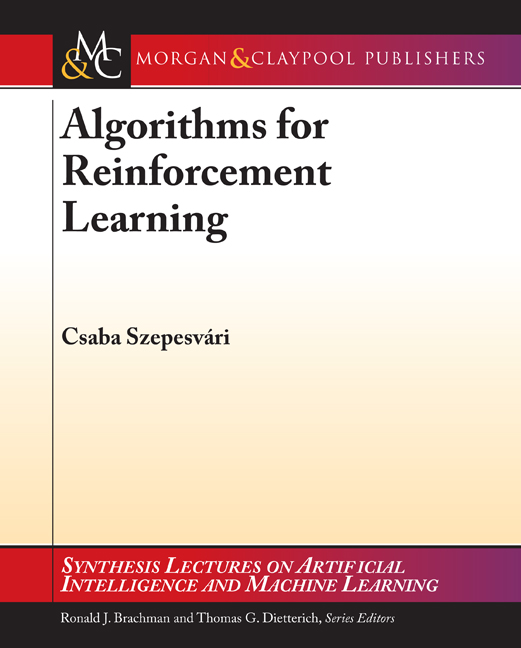</td>
<td>**Algorithms for Reinforcement Learning**<br>Csaba Szepesvari<br>2010.<br>The essentials in 104 pages. A bit mathematical.<br>PDF available <a href="https://sites.ualberta.ca/~szepesva/RLBook.html">here</a> (last update in 2017).</td>
</tr>
<tr>
<td>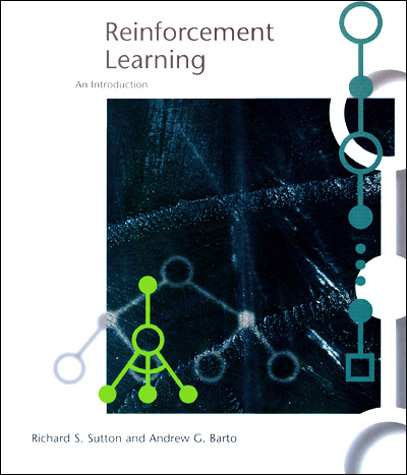</td>
<td>**Reinforcement Learning: an introduction**<br>Richard Sutton and Andrew Barto<br>1998.<br>The Reinforcement Learning bible. Both complete and didactical.<br>2nd edition scheduled in 2018, available as an online draft.<br><a href="http://incompleteideas.net/book/the-book.html">Online versions</a> of the <a href="http://incompleteideas.net/book/the-book-1st.html">1st</a> and <a href="http://incompleteideas.net/book/the-book-2nd.html">2nd</a> editions.</td>
</tr>
<tr>
<td>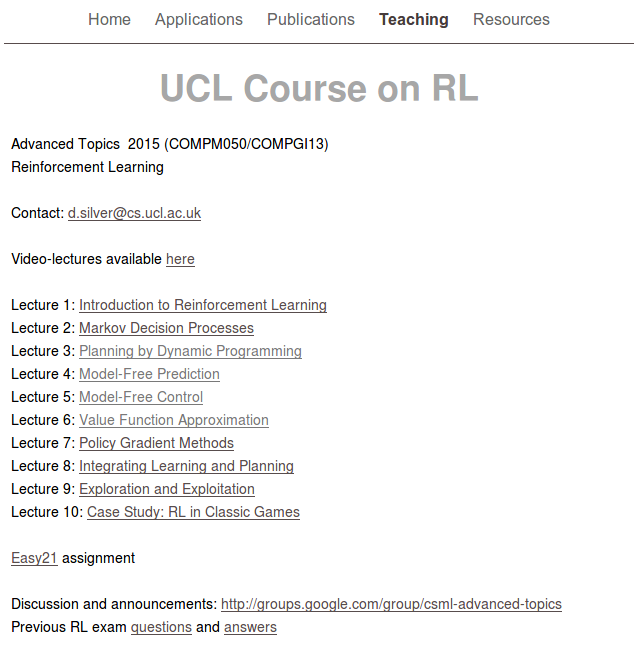</td>
<td>**David Silver's UCL course on RL**<br>10 video lectures + presentation PDFs.<br>2015.<br><a href="http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching.html">Available here</a>.</td>
</tr>
<tr>
<td>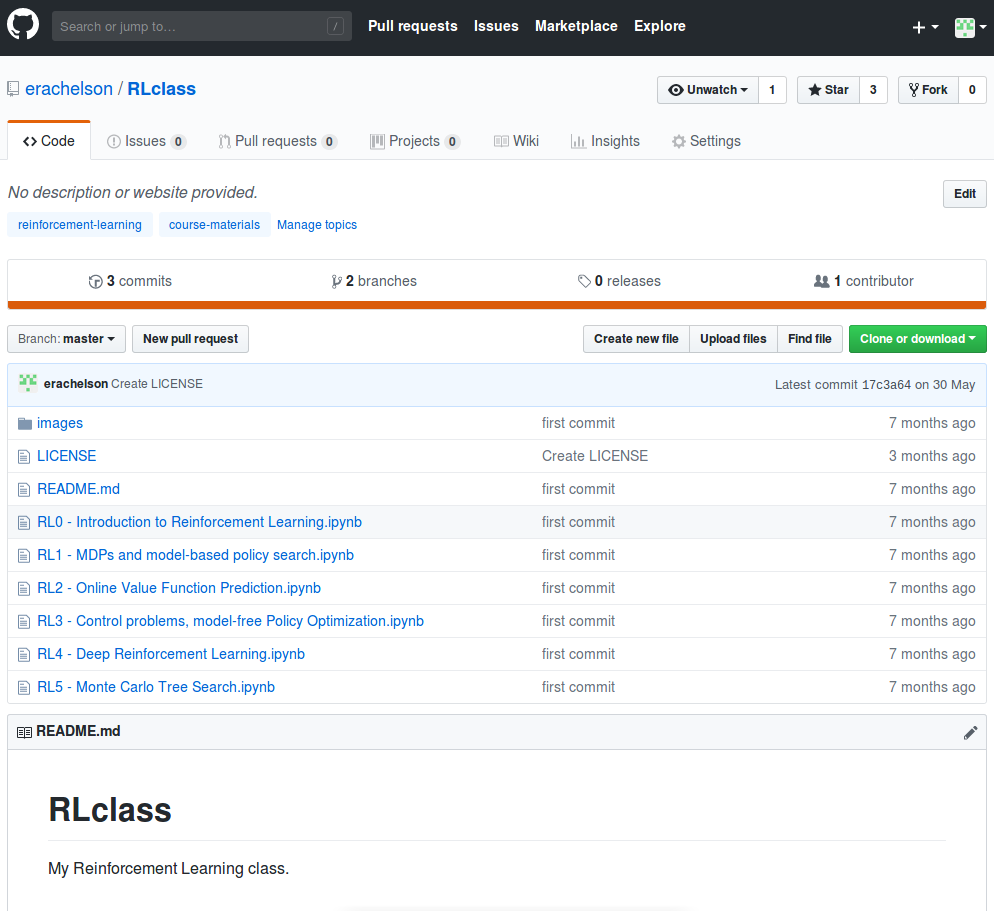</td>
<td>**Emmanuel Rachelson's ISAE-SUPAERO course on RL**<br>7 Python notebooks.<br>2018.<br><a href="https://github.com/erachelson/RLclass">Available here</a>.</td>
</tr>
</table>

**Table of contents**
1. [What is Reinforcement Learning ?](#sec1)
2. [Let's have fun, let's learn to play Breakout](#sec2)
3. [Moving towards real-life problems](#sec3)
4. [A bit of theory](#sec4)
5. [Your turn to play](#sec5)


# <a id="sec1"></a> 1. What is Reinforcement Learning?

Reinforcement Learning is the discipline that studies how one can learn to control a system through interaction.

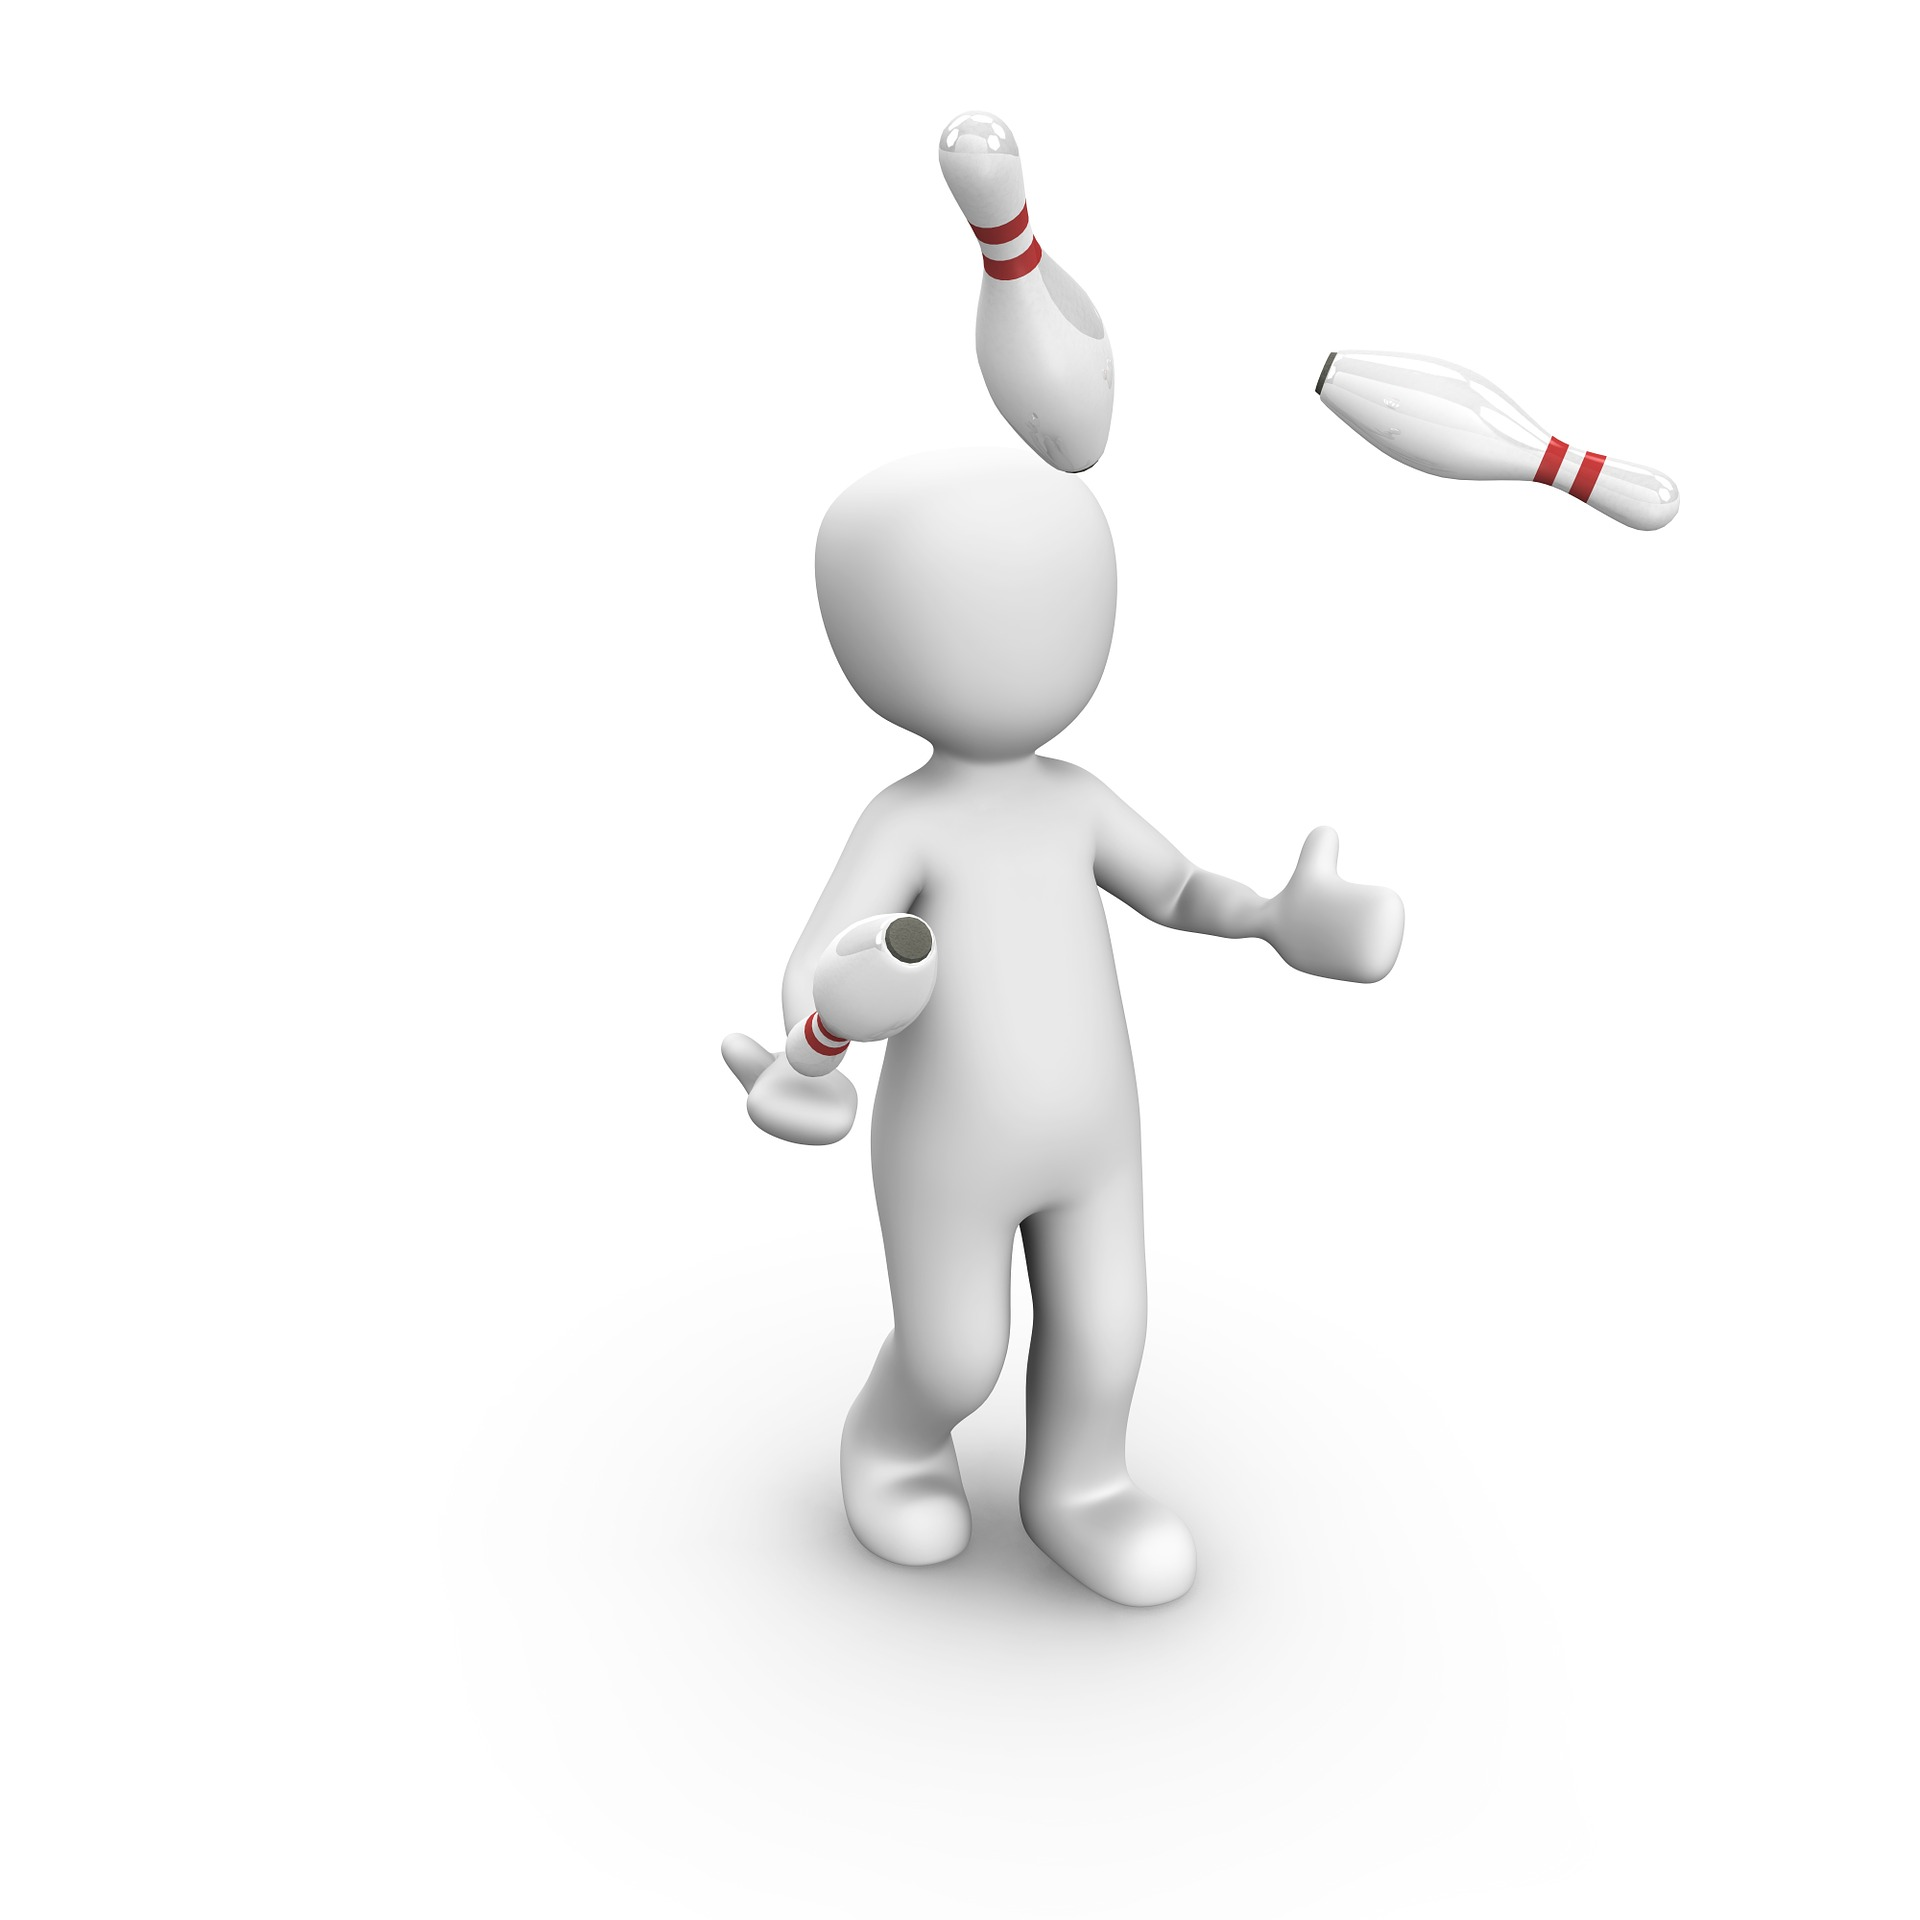

- No model
- The *learning* version of Stochastic Optimal Control.
- Applies to industrial scheduling, robotics control, Go playing...

<div class="alert alert-success"> **The goal in RL**<br>
Construct a close-loop control policy that maximizes a certain criterion, based on interaction data.
</div>

# <a id="sec2"></a> 2. Let's have fun, let's learn to play Breakout

## Breakout

Breakout is an old Atari 2600 game. Let's play a little with the OpenAI Gym environment.

In [ ]:
import gym
import gym.envs.atari as atari
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
np.set_printoptions(precision=3)

In [ ]:
env = gym.make('BreakoutDeterministic-v0')

In [ ]:
print(env.observation_space)
print(env.observation_space.shape)
print(np.min(env.observation_space.low))
print(np.max(env.observation_space.high))
print(env.action_space)

In [ ]:
x = env.reset()
plt.imshow(x)
plt.show()

In [ ]:
env.reset()
env.step(1)
env.render()
for i in range(150):
    a = 2+np.random.randint(2)
    env.step(a)
    env.render()
env.step(1)
for i in range(150):
    a = 2+np.random.randint(2)
    env.step(a)
    env.render()

In [ ]:
env.close()

The 4 available actions in Breakout are as follows:
- 0 NOOP (no operation)
- 1 FIRE (press fire button)
- 2 RIGHT (move paddle right)
- 3 LEFT (move paddle left)

Let's observe the output of an `env.step(a)` command.

In [ ]:
env.reset()
s, r, d, info = env.step(1)
print(s.shape)
print(r)
print(d)
print(info)

Whenever we press a button, the `step` function returns:
- the next screen, 
- a "reward" signal indicating how much we've won during this time step,
- a boolean indicating if we've lost,
- some extra information.

So that's pretty close to the information a human player would have, time step after time step (no ball coordinates, no velocities, etc. just the raw RBG image).

<div class="alert alert-warning">
Let's discuss for a minute how you believe a human player learns to play Breakout.
</div>

## Deep Q-learning

We are going to replicate the results that were introduced in the crucial paper **[Playing Atari with Deep Reinforcement Learning](https://arxiv.org/abs/1312.5602)** by Mnih et al. (2013) and were later improved by DeepMind's paper in Nature **[Human-level control through deep reinforcement learning](https://deepmind.com/research/publications/human-level-control-through-deep-reinforcement-learning)** by Mnih et al. (2015).

We are going to need a few pre-requisites that we will introduce with as little theory as possible.

We're going to implement Q-learning, the most classic RL algorithm. To do so, we need to introduce the notion of Q-values (we will call it Q-value of Q-function indistinctively).

<div class="alert alert-success">**Q-values**<br>
The Q-value of an "image, action" pair indicates how much we can expect to score if we start by performing this action, from the current image. So $Q(image,action)$ ranks actions in a given state of the game. For simplicity, we will write it $Q(s,a)$.
</div>

So if we know the best possible $Q$-function, we have actually solved our problem since we only need to act greedily with respect to this function. The goal of Q-learning is precisely to learn this optimal Q-function that we will write $Q^*$ (more details on this in the theory part).

Suppose we have a current estimate $Q$ for the optimal Q-function and we have just played $a$ in state $s$. That is, we have observed the $(s,a,r,s')$ transition, where:
- $s$ is the starting state (image)
- $a$ is the action performed
- $r$ is the transition's observed reward
- $s'$ is the reached state (image)

Then one can remark that the sum $r + \max_{a'} Q(s',a')$ gives an estimate of how much we can get in the long run. Of course, if $Q$ is close to $Q^*$, then this estimate is good. Otherwise, this estimate is poor.

To discriminate between a reward obtained now and another obtained in one time step, we introduce a *discount* factor $\gamma$ on future rewards. So the overall score estimate is $r + \gamma \max_{a'} Q(s',a')$

We can compare this estimate $r + \gamma \max_{a'} Q(s',a')$ to what we actually believed was the value of the $(s,a)$ pair *before* we tried action $a$ and compute a correction term that we will call a temporal difference:

$$\delta=r+\gamma \max_{a'} Q(s',a') - Q(s,a)$$

The temporal difference (TD in short) measures the difference in the estimate of $Q^*$ before and after obtaining the sample $(s,a,r,s')$. Ideally, we want to "pull" the estimate of $Q^*(s,a)$ towards $r+\gamma \max_{a'} Q(s',a')$. So that means pulling it in the direction of the temporal difference.

So this gives a straightforward algorithm:

<div class="alert alert-success">**Q-learning**<br>
Repeat:
<ol>
<li> In $s$, choose $a$
<li> Observe $r$, $s'$
<li> Temporal difference: $\delta=r+\gamma \max_{a'} Q(s',a') - Q(s,a)$
<li> Update $Q$: $Q(s,a) \leftarrow Q(s,a) + \alpha \delta$
<li> $s\leftarrow s'$
</ol>
</div>

<div class="alert alert-warning">**Brainstorming**<br>
What conditions do you think we should impose for this procedure to work?
</div>

<a href="#1" data-toggle="collapse"> Answers (click to uncover).</a><br>
<div id="1" class="collapse">
<ul>
<li> We need to obtain samples for every $(s,a)$ pair so the action selection procedure should **explore**. That means every $(s,a)$ pair should be visited often enough to let $Q(s,a)$ converge. But we're more interested in fast convergence in state-action pairs that yield high scores, so we would also like to focus on them and thus **exploit** already acquired knowledge. This is called the exploration versus exploitation compromise.
<li> Writing $Q(s,a) \leftarrow Q(s,a) + \alpha \delta$ means that for every experience sample $(s,a,r,s')$ we take a small step towards a (hopefully) better estimate of $Q^*$. This is a well-known problem in optimization called *stochastic approximation* and popularized in recent years under the name of *Stochastic Gradient Descent* (SGD). SGD is guaranteed to converge under certain conditions on the step size $\alpha$, which we will study in the theoretical part.
</div>

## Deep neural networks and Q-learning

An issue with the writing above is that, to obtain the true optimal Q-function, we need to collect enough representative samples in all states $s$ and all actions $a$. Let's make a quick calculation, there are:
- $256^{210 \times 160 \times 3} \sim 10^{242579}$ possible images
- 4 actions

So that's really a lot of values.

But one can remark two things:
- the images that will actually be seen are way less numerous
- two "close" images are likely to have "close" optimal Q-values

So we would like to learn an approximation function that maps state-action pairs to a scalar value, that we can train incrementally. Neural networks are just perfect for that task and deep neural networks have been the base of impressive results in the last decade. Additionnaly, our state is an image so that's even better: we can use convolutional neural networks (CNN) that learn functions over images and are at the core of the Deep Learning revolution.

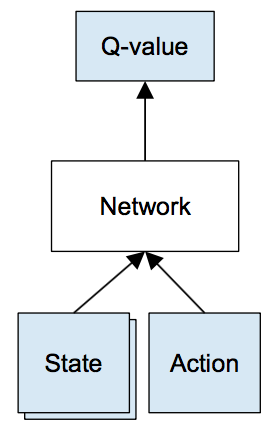</img>

Let's modify slightly the previous algorithm to include a neural network $f$ as a Q-function approximator.

<blockquote>
Repeat:
<ol>
<li> In $s$, choose $a$ (*GLIE actor*)
<li> Observe $r$, $s'$
<li> Define $x=(s,a)$ and $y=r+\gamma \max_{a'} f(s',a')$
<li> $f$.train(x,y)
<li> $s\leftarrow s'$
</ol>
</blockquote>


# State definition

If we define the game's state to hold only the last frame, it might not be enough to define an informative enough state. For instance, having just a snapshot image only gives us the position of the ball but not its velocity. So we will expand the state so that it contains the 4 last frames from the game.

One frame is a $210\times 160$ RGB image with a 256 color palette, so the set of all possible frames has size $256^{210 \times 160 \times 3} \sim 10^{242579}$. That's a little too many for an efficient enumeration. Even by converting the image to greyscale, downsampling to a $110\times 84$ and then cropping to an $84\times 84$ image to keep only the playing area (as we shall do a little later to slightly simplify the problem), that's still around $10^{16980}$ possible stages. So, definitely, this discrete problem is not suitable for complete enumeration.

Of course, most of the possible images will never occur in a Breakout game and the true state space is actually a much smaller subset of the full set of possible images. Nevertheless, unless we provide a large engineering effort in describing the state space with few variables (which would be contradictory of our goal of a "human-level" AI) we will need to automatically discover some structure in the state sampled data, hence justifying our usage of deep neural networks.

In [ ]:
from skimage.color import rgb2gray
from skimage.transform import resize

def process_screen(x):
    return 256*resize(rgb2gray(x), (110,84))[17:101,:]

y=process_screen(x)
plt.imshow(y, cmap="gray")
plt.show()
print(y.shape)

In [ ]:
# stack the 4 last frames
z = np.stack([y,y,y,y],axis=-1)
print(z.shape)

## A specific neural network structure

Let's define a Convolutional Neural Network (CNN) that will predict our Q-values. When we choose a greedy action, we need to evaluate $Q(s,a)$ for all possible $a$. So in our case, that means propagating $(s,a)$ values 4 times through our network. It would be more efficient to build a network that predicts the values of the 4 actions in a single pass for a given state $s$. So we define the input of our Q-network as the state only, and the output as the 4-dimensional vector evaluating each action.

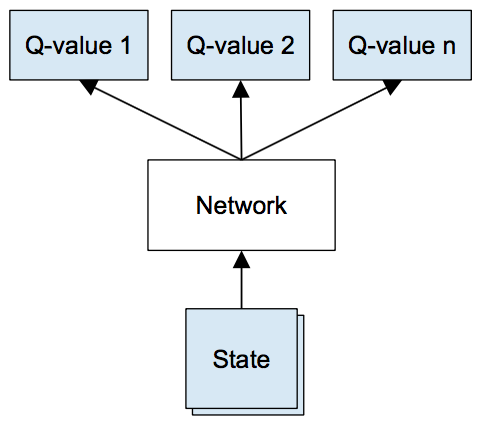</img>

Then, our network has the following structure:
- input: $84\times 84\times 4$ image (the last 4 frames)
- layer 1: Convolutions with 16 filters of size $8\times 8$ and stride 4. The activation is a ReLU function.
- layer 2: Convolutions with 32 filters of size $4\times 4$ and stride 2. The activation is a ReLU function.
- layer 3: Fully connected with 256 ReLU units
- layer 4 (output): Fully connected with 4 linear units (one for each action's value)

Graphically, this yields the following network structure.
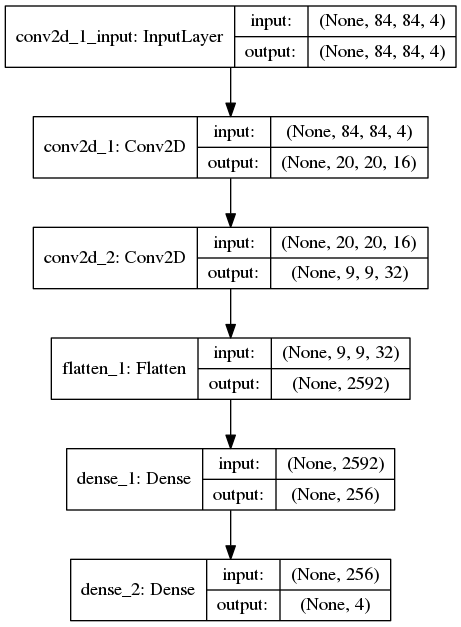</img>

We refer to this type of CNN as *Deep Q-Networks* (DQN).

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten

dqn = Sequential()
#1st layer
dqn.add(Conv2D(filters=16, kernel_size=(8,8), strides=4, activation="relu", input_shape=(84,84,4)))
#2nd layer
dqn.add(Conv2D(filters=32, kernel_size=(4,4), strides=2, activation="relu"))
dqn.add(Flatten())
#3rd layer
dqn.add(Dense(units=256, activation="relu"))
#output layer
dqn.add(Dense(units=4, activation="linear"))

dqn.compile(optimizer="rmsprop", loss="mean_squared_error")

#from keras.utils import plot_model
#plot_model(dqn, to_file="images/dqn_keras.png", show_shapes=True)

## Experience Replay

Neural networks learn better when the samples are fed to them in *mini-batches* rather than one by one. To implement this, our algorithm must remember the mapping $s,a\mapsto r+\gamma\max_{a'}Q(s',a')$ for all the $(s,a)$ in a given mini-batch. So that means keeping a memory of the $(s,a,r,s')$ samples.

But if we're going to store the $(s,a,r,s')$ samples, we might as well use each of them several times, to build increasingly better values for $r+\gamma\max_{a'}Q(s',a')$, as $Q$ gets more accurate (close to $Q^*$). This leads to the idea of *Experience Replay*: we store a *replay memory* of experience samples, among which we randomly draw elements that will constitute our mini-batch.

Given this last idea, lets implement an Experience Replay Q-learning using our DQN. The algorithm's pseudo-code is:

         state = init()
         loop:
            action = greedy_action(network) or random_action()
            new_state, reward = step(state, action)
            replay_memory.add(state, action, reward, new_state)
            minibatch = replay_memory.sample(minibatch_size)
            X_train = Y_train = []
            for (s,a,r,s') in minibatch:
                Q  = network.predict(s)
                Q' = network.predict(s')
                if non-terminal(s'): 
                    update = r + gamma * max(Q')    
                else:  
                    update = r
                Q[a] = update
                X_train.add(s)
                Y_train.add(Q)
            network.train_one_step(X_train,Y_train)
            state = new_state

A few algorithmic details:
- Total number of steps: $10^7$.
- Replay memory size: $10^6$ samples.
- Mini-batch size: $32$ samples.
- $\gamma = 0.99$
- Reward clipping. To control the scale of the global scores, clip the rewards so that all strictly positive rewards are $+1$, all zero rewards remain at $0$, and strictly negative rewards become $-1$.
- Epsilon greedy. Decrease linearly $\epsilon$ from $1$ to $0.1$ over the first million steps and keep it at $0.1$ thereafter.

<div class="alert-danger">**Warning:** the network training defined below might take very (very!) long. For example, on an i7 CPU with no GPU it takes about 10 days. Also, the replay memory of $10^7$ samples uses around 10Gb of RAM as defined below. If your machine's resources are below that, you might want to scale down the replay memory size. Therefore, only run this code if you have time ahead of you. A simpler example is given later in the notebook.</div>

In [ ]:
total_steps = 10000000
replay_memory_size = 100000
mini_batch_size = 32
gamma = 0.99

def epsilon(step):
    if step<1e6:
        return 1.-step*9e-7
    return .1

def clip_reward(r):
    rr=0
    if r>0:
        rr=1
    if r<0:
        rr=-1
    return rr

def greedy_action(network, x):
    Q = network.predict(np.array([x]))
    return np.argmax(Q)

def MCeval(network, trials, length, gamma):
    scores = np.zeros((trials))
    for i in range(trials):
        screen_x = process_screen(env.reset())
        stacked_x = deque([screen_x, screen_x, screen_x, screen_x], maxlen=4)
        x = np.stack(stacked_x, axis=-1)
        for t in range(length):
            a = greedy_action(network, x)
            raw_screen_y, r, d, _ = env.step(a)
            r = clip_reward(r)
            screen_y = process_screen(raw_screen_y)
            scores[i] = scores[i] + gamma**t * r
            if d==True:
                # restart episode
                screen_x = process_screen(env.reset())
                stacked_x = deque([screen_x, screen_x, screen_x, screen_x], maxlen=4)
                x = np.stack(stacked_x, axis=-1)
            else:
                # keep going
                screen_x = screen_y
                stacked_x.append(screen_x)
                x = np.stack(stacked_x, axis=-1)
    return np.mean(scores)


In [ ]:
# A class for the replay memory
from collections import deque

class MemoryBuffer:
    "An experience replay buffer using numpy arrays"
    def __init__(self, length, screen_shape, action_shape):
        self.length = length
        self.screen_shape = screen_shape
        self.action_shape = action_shape
        shape = (length,) + screen_shape
        self.screens_x = np.zeros(shape, dtype=np.uint8) # starting states
        self.screens_y = np.zeros(shape, dtype=np.uint8) # resulting states
        shape = (length,) + action_shape
        self.actions = np.zeros(shape, dtype=np.uint8) # actions
        self.rewards = np.zeros((length,1), dtype=np.uint8) # rewards
        self.terminals = np.zeros((length,1), dtype=np.bool) # true if resulting state is terminal
        self.terminals[-1] = True
        self.index = 0 # points one position past the last inserted element
        self.size = 0 # current size of the buffer
    
    def append(self, screenx, a, r, screeny, d):
        self.screens_x[self.index] = screenx
        #plt.imshow(screenx)
        #plt.show()
        #plt.imshow(self.screens_x[self.index])
        #plt.show()
        self.actions[self.index] = a
        self.rewards[self.index] = r
        self.screens_y[self.index] = screeny
        self.terminals[self.index] = d
        self.index = (self.index+1) % self.length
        self.size = np.min([self.size+1,self.length])
    
    def stacked_frames_x(self, index):
        im_deque = deque(maxlen=4)
        pos = index % self.length
        for i in range(4): # todo
            im = self.screens_x[pos]
            im_deque.appendleft(im)
            test_pos = (pos-1) % self.length
            if self.terminals[test_pos] == False:
                pos = test_pos
        return np.stack(im_deque, axis=-1)
    
    def stacked_frames_y(self, index):
        im_deque = deque(maxlen=4)
        pos = index % self.length
        for i in range(4): # todo
            im = self.screens_y[pos]
            im_deque.appendleft(im)
            test_pos = (pos-1) % self.length
            if self.terminals[test_pos] == False:
                pos = test_pos
        return np.stack(im_deque, axis=-1)
    
    def minibatch(self, size):
        #return np.random.choice(self.data[:self.size], size=sz, replace=False)
        indices = np.random.choice(self.size, size=size, replace=False)
        x = np.zeros((size,)+self.screen_shape+(4,))
        y = np.zeros((size,)+self.screen_shape+(4,))
        for i in range(size):
            x[i] = self.stacked_frames_x(indices[i])
            y[i] = self.stacked_frames_y(indices[i])
        return x, self.actions[indices], self.rewards[indices], y, self.terminals[indices]

In [ ]:
# initialize state and replay memory
screen_x = process_screen(env.reset())
stacked_x = deque([screen_x, screen_x, screen_x, screen_x], maxlen=4)
x = np.stack(stacked_x, axis=-1)
replay_memory = MemoryBuffer(replay_memory_size, (84, 84), (1,))
# initial state for evaluation
evaluation_period = 10000
Xtest = np.array([x])
nb_epochs = total_steps // evaluation_period
epoch=-1
scoreQ = np.zeros((nb_epochs))
scoreMC = np.zeros((nb_epochs))

# Deep Q-learning with experience replay
for step in range(total_steps):
    # evaluation
    if(step%10000 == 0):
        epoch = epoch+1
        # evaluation of initial state
        scoreQ[epoch] = np.mean(dqn.predict(Xtest).max(1))
        # roll-out evaluation
        scoreMC[epoch] = MCeval(network=dqn, trials=20, length=700, gamma=gamma)
    # action selection
    if np.random.rand() < epsilon(step):
        a = np.random.randint(env.action_space.n)
    else:
        a = greedy_action(dqn, x)
    # step
    raw_screen_y, r, d, _ = env.step(a)
    r = clip_reward(r)
    screen_y = process_screen(raw_screen_y)
    replay_memory.append(screen_x, a, r, screen_y, d)
    # train
    if step>mini_batch_size:
        X,A,R,Y,D = replay_memory.minibatch(mini_batch_size)
        QY = dqn.predict(Y)
        QYmax = QY.max(1).reshape((mini_batch_size,1))
        update = R + gamma * (1-D) * QYmax
        QX = dqn.predict(X)
        QX[np.arange(mini_batch_size), A.ravel()] = update.ravel()
        dqn.train_on_batch(x=X, y=QX)
    # prepare next transition
    if d==True:
        # restart episode
        screen_x = process_screen(env.reset())
        stacked_x = deque([screen_x, screen_x, screen_x, screen_x], maxlen=4)
        x = np.stack(stacked_x, axis=-1)
    else:
        # keep going
        screen_x = screen_y
        stacked_x.append(screen_x)
        x = np.stack(stacked_x, axis=-1)

If you actually run the code above, it is likely that the neural network will not converge to a good estimate of $Q^*$ and might even diverge. There are a couple of extra tricks that improve the previous algorithms, in particular the introduction of *target networks* but we avoid them for the sake of simplicity.

Additionnaly, there are many (really many) ways to make the learning drastically more efficient. The field has been blooming for the last years. Parallelization, sample efficiency, distribution estimation, network stabilization... many hot topics are still open research areas and the progress has been incredibly fast.

Below is a video of what you should get (along and) after training:

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo("TmPfTpjtdgg")

# <a id="sec3"></a> 3. Moving towards real-life problems

Ok, that was fun. We now have an intuitive understanding of a learning procedure that moves towards an optimal strategy. Let's take a step back and consider how this can help us for more "serious", real-life problems.

Consider the following problems:

- stabilizing a double inverted pendulum

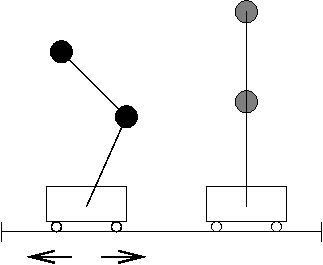

- Scheduling elevator movements

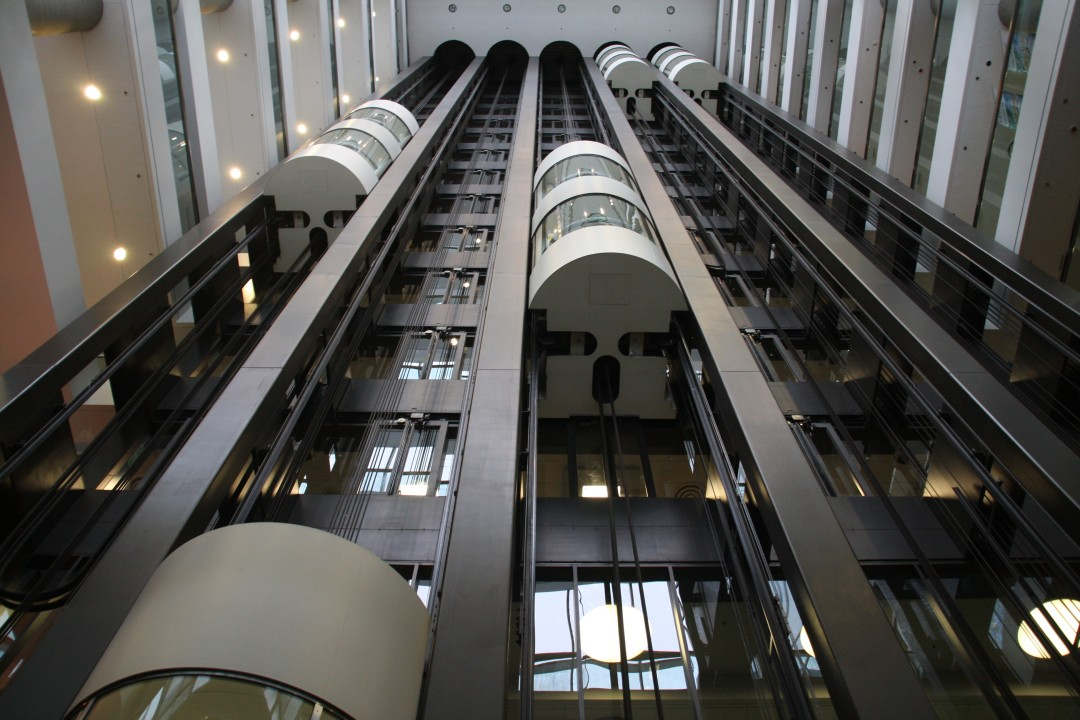

- Fluid flow control

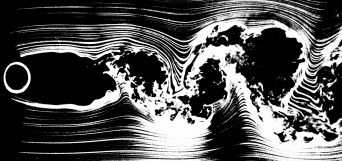

- Game playing

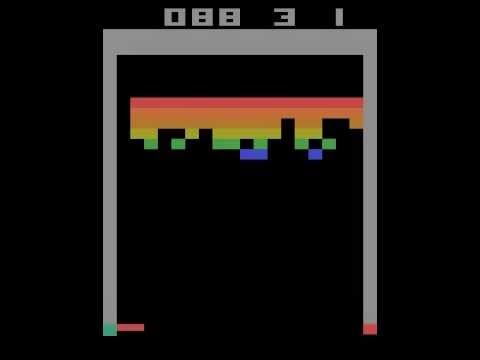

- Traffic jam navigation

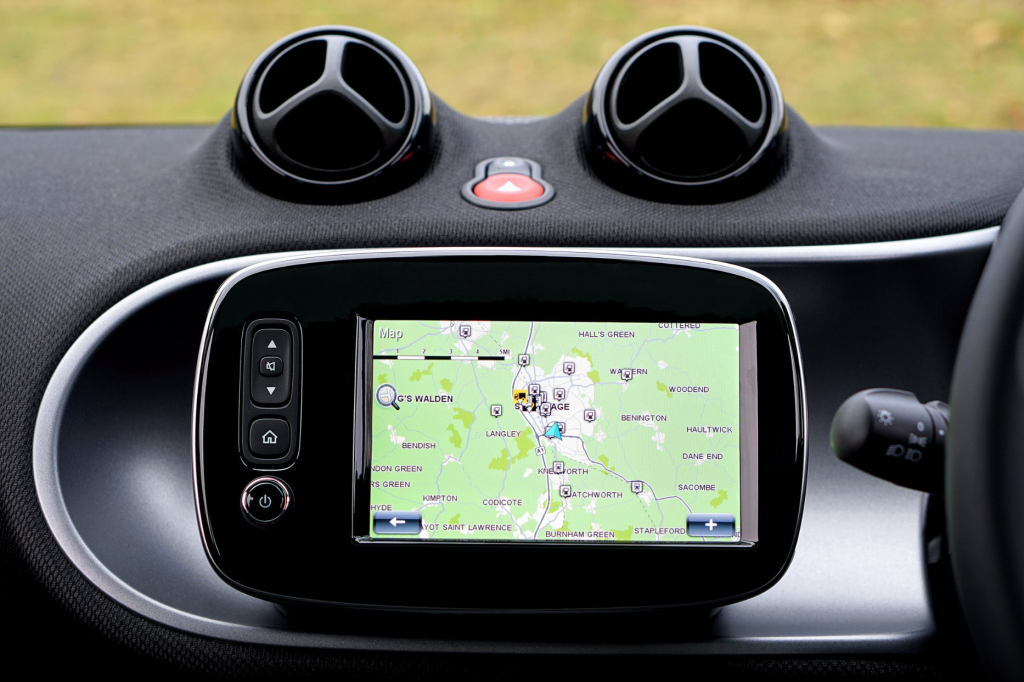

But also:
- motor skill aquisition
- agro-ecosystems policy design
- supply-chain management and vehicle routing
- frequency allocation in LEO telecom satelites
- chatbot dialog strategy
- etc.

<div class="alert alert-warning"> **Brainstorming**<br>
Can you see why all these problems fall into a common category? Can you describe this category of problems?
</div>

<a href="#2" data-toggle="collapse"> Answer (click to expand).</a><br>
<div id="2" class="collapse">
<ul>
    <li> Sequences of decisions (actions), </li>
    <li> Stochastic, complex, non-linear dynamics (possibly), </li>
    <li> No available formal model, </li>
    <li> Goal: closed-loop control policies (strategies, control laws, behaviours), </li>
    <li> Goal: find an optimal behaviour. </li>
</ul>

In technical terms, this is the framework of **Discrete-time Stochastic Optimal Control**. Reinforcement Learning is the set of procedures that try to solve this family of problem **without** the elaboration of a model, using **interaction data** directly.

Let is rephrase the above statements with a drawing and a more AI-ish vocabulary.

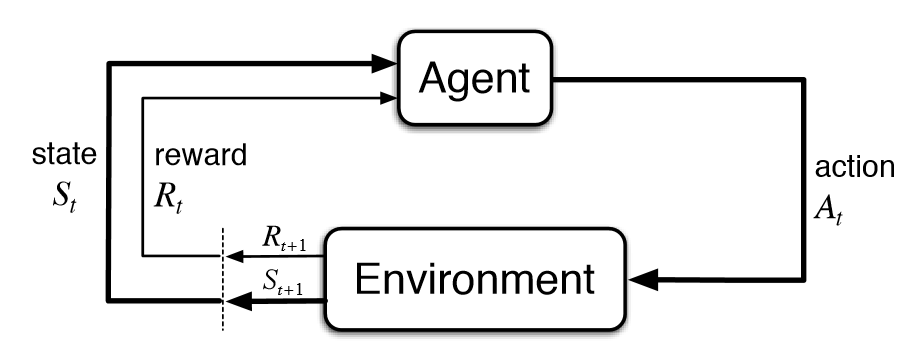

We consider an agent that needs to take a sequence of decisions (*discrete-time*), so that its overall behaviour (*control*) is a good as possible (*optimal*) in an environment whose dynamics are possibly *stochastic*. At each time step, the RL agent observes a *reward signal* indicating how much he gained from the last transition between states. The RL agent tries to find the optimal behaviour without a model of the environment and though interaction data.
</div>

So the key idea of RL is that powerful enough learning procedures can help tackle these difficult problems.

<div class="alert alert-success">**Caveat**<br>
RL is **not** the solution to all your control problems.
<ul>
    <li> If you have a reliable model and good analysis tools (Dynamic Programming, Linear Control Theory, Operations Research models...), use them!
    <li> Many RL methods are slow, sample-inefficient, unstable, etc. Even if great successes are being obtained, don't be fooled, there is still lots of research to be done before the field reaches a full maturity.
    <li> There are probably many other reasons.
</ul>
I'm a researcher in RL. I hope to convince you that RL is a great investigation topic with an awesome potential. But I also want you to keep a critic eye on the field.
</div>

<div class="alert alert-success">**A few key fundamental issues in RL:**<br>
<ul>
    <li> The exploration/exploitation compromise, deceptive rewards,
    <li> Value function approximation quality,
    <li> Convergence guarantees and speed,
    <li> Parametrized policies and value functions, Actor-Critic architectures, etc.
</ul>
</div>

<div class="alert alert-success">**A few key practical issues in RL:**<br>
<ul>
    <li> Reproducibility and statistical representativity,
    <li> Robustness and transferability,
    <li> Safety,
    <li> Computationnal burden, scaling up.
</ul>
</div>

# <a id="sec4"></a> 4. A bit of theory

Let's formalize this a little on the white board. Here are the topics we should cover to provide a sound foundation to the experiment above:
- Markov Decision Processes,
- Policies, optimality criteria and Value functions,
- Bellman's optimality principle (and the corresponding equations),
- Q-learning is a stochastic optimization procedure.

We can also decide to skip this part if you want to play a little.

# <a id="sec5"></a> 5. Your turn to play

There are endless practice opportunities. I suggest two options below.
1. [The first challenge](#frozenlake) is a really easy game called FrozenLake. It is a discrete environment, easy to solve. It is provided in order to help you play around with the different concepts of Q-learning without any value function approximation.
2. [The second challenge](#tictactoe) is an opening. Will you be able to design a Deep Tic-Tac-Toe learner?

## <a id="frozenlake"></a> Frozen lake

In [ ]:
import gym
import gym.envs.toy_text.frozen_lake as fl
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
np.set_printoptions(precision=3)

In [ ]:
env = gym.make('FrozenLake-v0')
_=env.render()

In [ ]:
help(fl.FrozenLakeEnv)

In [ ]:
print(env.action_space)
print(env.observation_space)
print(env.observation_space.n)
print("Reset: ", env.reset())
print("Step right:", env.step(fl.RIGHT))
env.render()
print("Second step right:", env.step(fl.RIGHT))
print("Third step right:", env.step(fl.RIGHT))
env.render()

Four utility functions and a bit of display help.

In [ ]:
def to_s(row,col):
    return row*env.unwrapped.ncol+col

def to_row_col(s):
    col = s%env.unwrapped.ncol
    row = int((s-col)/env.unwrapped.ncol)
    return row,col

actions = {fl.LEFT: '\u2190', fl.DOWN: '\u2193', fl.RIGHT: '\u2192', fl.UP: '\u2191'}
print(actions)

def greedyQpolicy(Q):
    pi = np.zeros((env.observation_space.n),dtype=np.int)
    for s in range(env.observation_space.n):
        pi[s] = np.argmax(Q[s,:])
    return pi

def print_policy(pi):
    for row in range(env.unwrapped.nrow):
        for col in range(env.unwrapped.ncol):
            print(actions[pi[to_s(row,col)]], end='')
        print()
    return

<div class="alert alert-warning"> **Your turn to play**<br>
Let's restart from scratch.
<ul>
    <li> Can you implement a good strategy by hand on paper?
    <li> Can you implement it?
    <li> Can you find a criterion to evaluate how good it is?
    <li> Can you implement a Q-learning agent for the FrozenLake game?
    <li> Monitor the convergence of $Q$ to $Q^*$.
    <li> What about the exploration/exploitation compromise?
</ul>
</div>

In order to help you study the convergence of Q-learning, we provide an approximate value for $Q^*$.

In [ ]:
Qstar = np.array([[ 0.068,  0.066,  0.066,  0.059],
 [ 0.039,  0.043,  0.04,   0.061],
 [ 0.074,  0.068,  0.072,  0.057],
 [ 0.039,  0.039,  0.033,  0.055],
 [ 0.091,  0.071,  0.064,  0.048],
 [ 0.,     0.,     0.,     0.   ],
 [ 0.112,  0.09,   0.112,  0.022],
 [ 0.,     0.,     0.,     0.   ],
 [ 0.071,  0.118,  0.102,  0.145],
 [ 0.157,  0.247,  0.204,  0.133],
 [ 0.299,  0.266,  0.225,  0.108],
 [ 0.,     0.,     0.,     0.   ],
 [ 0.,     0.,     0.,     0.   ],
 [ 0.188,  0.306,  0.38,   0.266],
 [ 0.395,  0.639,  0.615,  0.537],
 [ 0.,     0.,     0.,     0.   ]])

In [ ]:
# %load solutions/frozenlake.py
### WRITE YOUR CODE HERE
# If you get stuck, uncomment the line above to load a correction in this cell (then you can execute this code).

## <a id="tictactoe"></a> Deep Tic-Tac-Toe learning

Let's implement the DQN algorithm on a simple Tic-Tac-Toe game.

Note that this is not a Stochastic Optimal Control problem *per se*: it is an adversarial, two-player game (while stochastic optimal control is limited to one-player games). But maybe you can imagine a way of adapting Q-learning to this setting (think about how AlphaGo found better-than-human strategies at Go).

This exercice is thus a way to push the boundaries of what we have seen before.

###  The board game

This is a quite simple implementation. The board is a tuple of size 9 where each action refers to a position in the tuple. We store the status of the current player and who won the game.

The main classes and objects:

* player(state) 
* available_move(state)
* next_state(state, action, current_player)
* win(board, player)
* payoff(current_player, state) 
* play(state, action)

In [ ]:
class oxo:
    def __init__(self):
        self.current_player = 1
        self.actions = [0, 1, 2, 3, 4, 5, 6, 7, 8]
        self.board = (0,0,0,0,0,0,0,0,0)
        self.nb_move = 0
        self.end_game = 0 # -1: null, O: running, 1: player 1 win, 2: player 2 win

    def play(self, state, action):
        self.current_player = self.player(state)
        stateList = list(self.board)
        stateList[action] = self.current_player
        self.board = tuple(stateList)
        self.nb_move += 1
        #print("nb move: ", self.nb_move)
        self.actions.remove(action)
        
        if self.asWin():
            self.end_game = self.current_player
        if self.nb_move == 9 and self.end_game == 0:
            self.end_game = -1

    def next_state(self, state, action, player):
        stateList = list(state)
        stateList[action] = player
        return tuple(stateList)

    def available_move(self, state):
        am = []
        i = 0;
        for x in state:
            if x == 0: 
                am += [i]
            i += 1
        return am

    def asWin(self):
        p = self.current_player
        b = self.board
        if (b[0] == b[1] == b[2] == p or b[3] == b[4] == b[5] == p or b[6] == b[7] == b[8] == p or
            b[0] == b[3] == b[6] == p or b[1] == b[4] == b[7] == p or b[2] == b[5] == b[8] == p or
            b[0] == b[4] == b[8] == p or b[2] == b[4] == b[6] == p):
            return True
        else: return False

    def win(self, b, p):
        if (b[0] == b[1] == b[2] == p or b[3] == b[4] == b[5] == p or b[6] == b[7] == b[8] == p or
            b[0] == b[3] == b[6] == p or b[1] == b[4] == b[7] == p or b[2] == b[5] == b[8] == p or
            b[0] == b[4] == b[8] == p or b[2] == b[4] == b[6] == p):
            return True
        else: return False
        

    # -1: running, 0; exaecquo, 1 player 1, 2 player 2    
    def payoff(self, p, b):
        nb_move = 0
        for i in b:
            if i != 0: nb_move += 1

        if self.win(b, 1):    return 1
        if self.win(b, 2):    return 2    
        if nb_move == 9: return 0        
        return -1

    def player(self, board):
        J1=0
        J2=0
        for i in board:
            if i==1: J1+=1 
            if i==2: J2+=1 
        if J1==J2: return 1
        return(2)

    def simulation(self):
        while self.end_game == 0:
            self.myPrint()
            print ("actions ", self.actions)
            action = int(input("Player %s: " % (self.current_player)))

            if action in self.actions: self.play(self.board, action)
            else: print ("wrong move, try again")

            if self.asWin(): 
                print("Player " , self.current_player , " win!!!")
                self.end_game = self.current_player

            if self.nb_move == 9 and self.end_game == 0: 
                print("No winner, No looser!")
                self.end_game == -1

            if self.current_player == 1: self.current_player = 2
            else: self.current_player = 1

    def myPrint(self):
        b = []
        for x in self.board:
            if x == 1: b.append('X')
            else: 
                if x == 2: b.append('O')
                else: b.append('.')
        print()
        print("     ", b[0] , "  " , b[1] , "  " , b[2], "       ", 0 , "  " , 1 , "  " , 2)
        print("     ", b[3] , "  " , b[4] , "  " , b[5], "  ->   ", 3 , "  " , 4 , "  " , 5)
        print("     ", b[6] , "  " , b[7] , "  " , b[8], "       ", 6 , "  " , 7 , "  " , 8)
        print()

### Can you implement an efficient DQN player?

We provide a test function below to let you play against your deep Q learning agent. It supposes `model` is a keras-style deep neural network. The second argument states if the AI plays first (`playerAI=1`) or second (`playerAI=1`).

In [ ]:
def testAlgo(model, playerAI):
    loop = True
    while (loop):
        jeu = oxo()
        #switch first player at each round
        if playerAI==1:
            playerAI=2
        else:
            playerAI=1
        #while game still in progress
        while(jeu.end_game==0):
            state = jeu.board
            current_player = jeu.player(state)
            b = current_player
            if b == 1: b='X'
            else: b = 'O'
            
            if current_player == playerAI: 
                
                qval = model.predict(np.array(state).reshape(1, len(state)), batch_size=batchSize)
                print("State=", state)
                print("Actions:", jeu.actions)
                for i in range(len(qval[0])):
                    print("     Action:", i, "Q-value:", qval[0][i])
                qval_av_action = [-9999]*9
                for ac in jeu.actions:
                    qval_av_action[ac] = qval[0][ac]
                #print(qval_av_action)
                action = (np.argmax(qval_av_action))
                print("Action:", action)
            else:
                jeu.myPrint()
                print ("action ", jeu.actions, " current_player = ", b)
                action = int(input("Player %s: " % (current_player)))
        
            if action == 10:
                loop=False
                break 
            
            if action in jeu.actions: 
                jeu.play(state, action)
            else: 
                print ("----- > Wrong move, try again!")
                
            if jeu.asWin():
                if current_player == playerAI:
                    print("-------------------------------")
                    print("--------->  AI WINS <----------")
                    print("-------------------------------")
                else:
                    print("-------------------------------")
                    print("----------> YOU WIN <----------")
                    print("-------------------------------")
             
            if jeu.nb_move == 9 and jeu.end_game == 0:
                print("-------------------------------")
                print("---> No winner, No looser <----")
                print("-------------------------------")
            
            #clear_output(wait=True)


In [ ]:
# %load solutions/tictactoe.py
### WRITE YOUR CODE HERE
# If you get stuck, uncomment the line above to load a correction in this cell (then you can execute this code).